In [1]:
%load_ext autoreload
%autoreload 2

from spear.flows import InOrOutPerYear
from spear.assets import Asset
from spear.events import Event
from spear.model import FinancialModel

In [2]:
salary = InOrOutPerYear(name="Salary", initial_value=0)
housing = InOrOutPerYear(name="Housing", initial_value=10_000)
cost_of_living = InOrOutPerYear(name="Cost of Living", initial_value=50_000)

cash = Asset(name="Cash", initial_value=20_000, growth_rate=0.01, cap_value=50_000)
bonds = Asset(name="Bonds", initial_value=20_000, growth_rate=0.03, allocation=0.3)
stocks = Asset(name="Stocks", initial_value=750_000, growth_rate=0.08, allocation=0.7)

In [4]:
planner = FinancialModel(
    revenues=[salary],
    expenses=[housing, cost_of_living],
    assets=[cash, bonds, stocks],
    duration=30,
)
planner.run()

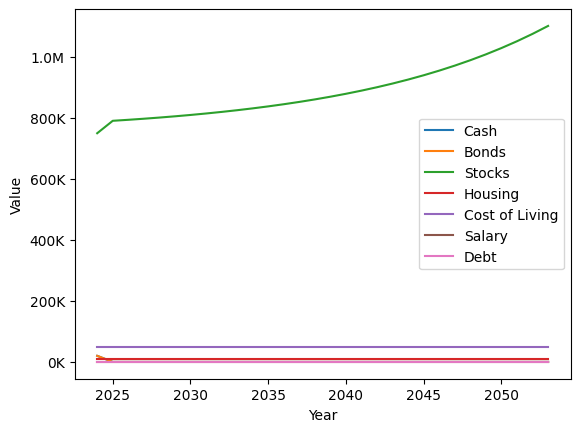

In [6]:
planner.plot_all();